In [71]:
# data processing
import pandas as pd
import numpy as np

# modelling
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, auc, roc_curve, accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
mnist = keras.datasets.mnist
(train_images, _), (test_images, _) = mnist.load_data()

x_train, x_val = train_test_split(train_images, test_size=0.2, random_state=42)

Dataset split: 48000 train rows
Dataset split: 12000 test rows


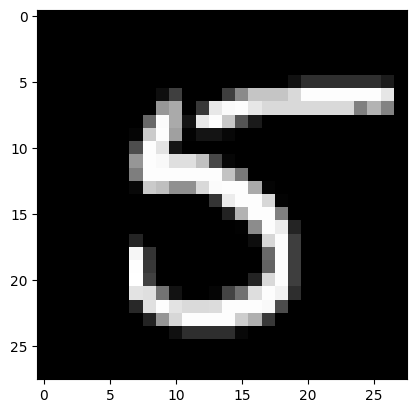

In [73]:
print(f"Dataset split: {len(x_train)} train rows")
print(f"Dataset split: {len(x_val)} test rows")

point = x_train[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [74]:
print(x_train.shape)
print(x_val.shape)
print(test_images.shape)

(48000, 28, 28)
(12000, 28, 28)
(10000, 28, 28)


In [75]:
# normalize data
x_train = x_train.astype(np.float32) / 255
x_val = x_val.astype(np.float32) / 255

# reshape
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)
test_images = test_images.reshape(-1, 784)

In [76]:
print(x_train.shape)
print(x_val.shape)
print(test_images.shape)

(48000, 784)
(12000, 784)
(10000, 784)


In [77]:
latent_dim = 2

In [78]:
# encoder
vae_input = keras.layers.Input(shape=(784,))
x = keras.layers.Dense(256, activation='relu')(vae_input)
x = keras.layers.Dense(128, activation='relu')(x)
z_mean = keras.layers.Dense(latent_dim)(x)
z_log_var = keras.layers.Dense(latent_dim)(x)

In [79]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [80]:
z = keras.layers.Lambda(lambda x: sampling(x))([z_mean, z_log_var])

In [81]:
# decoder
decoder_input = keras.layers.Input(shape=(latent_dim,))
x = keras.layers.Dense(128, activation='relu')(decoder_input)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(784, activation='sigmoid')(x)
decoded = x

In [82]:
# Encoder model
encoder = keras.models.Model(inputs=vae_input, outputs=[z_mean, z_log_var, z])

# Decoder model
decoder = keras.models.Model(inputs=decoder_input, outputs=decoded)

In [83]:
vae_output = decoder(encoder(vae_input)[2])
vae = keras.models.Model(inputs=vae_input, outputs=vae_output)

In [84]:
# class CustomLossLayer(keras.layers.Layer):
#     def call(self, inputs):
#         x, x_decoded_mean, z_mean, z_log_var = inputs
#         reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean))
#         kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
#         kl_loss = -0.5 * tf.reduce_mean(kl_loss, axis=-1)
#         vae_loss = reconstruction_loss + kl_loss
#         self.add_loss(vae_loss, inputs=inputs)
#         return x

In [85]:
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean))
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = -0.5 * tf.reduce_mean(kl_loss, axis=-1)
    vae_loss = reconstruction_loss + kl_loss
    return vae_loss

vae.add_loss(vae_loss(vae_input, vae_output))

In [86]:
vae.compile(optimizer='adam')

In [87]:
vae.fit(x_train, x_train, epochs=20, batch_size=64, validation_data=(x_val, x_val))

Epoch 1/20


750/750 [==============================] - 7s 8ms/step - loss: 0.0729 - val_loss: 0.0673
Epoch 2/20
750/750 [==============================] - 5s 7ms/step - loss: 0.0675 - val_loss: 0.0672
Epoch 3/20
750/750 [==============================] - 5s 7ms/step - loss: 0.0675 - val_loss: 0.0672
Epoch 4/20
750/750 [==============================] - 5s 7ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 5/20
750/750 [==============================] - 5s 7ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 6/20
750/750 [==============================] - 5s 7ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 7/20
750/750 [==============================] - 6s 8ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 8/20
750/750 [==============================] - 6s 8ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 9/20
750/750 [==============================] - 6s 8ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 10/20
750/750 [==============================] - 6s 8ms/step - loss: 0.0674 - val_loss: 0.0670
Epoch 11/2

In [88]:
decoded_images = vae.predict(test_images)

# calculate the reconstruction error for each sample
reconstruction_errors = np.mean(np.square(test_images - decoded_images), axis=1)

313/313 [==============================] - 1s 2ms/step


In [89]:
# define a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies based on the threshold
anomaly_indexes = np.where(reconstruction_errors > threshold)[0]

In [90]:
# Get all the anomalies from the test_images
anomalies = test_images[anomaly_indexes]

In [91]:
print(len(anomalies))

500


In [92]:
# Save the anomaly indexes to a file
with open("anomaly_indexes.txt", "w") as file:
    for idx in anomaly_indexes:
        file.write(str(idx) + "\n")

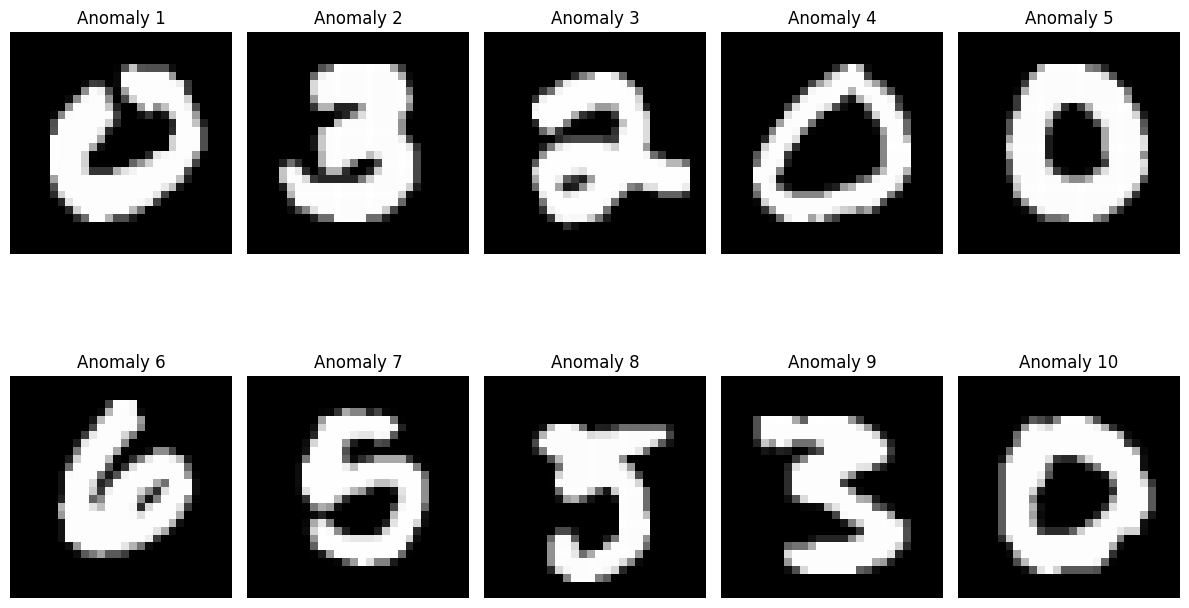

In [93]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomalies
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

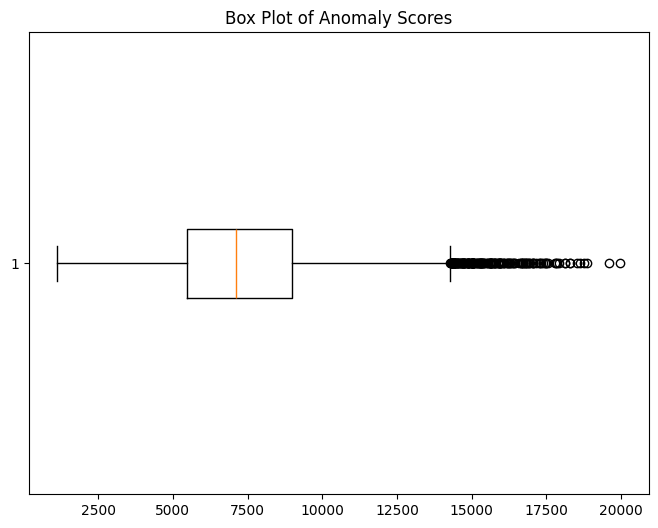

In [94]:
plt.figure(figsize=(8, 6))
plt.boxplot(reconstruction_errors, vert=False)
plt.title('Box Plot of Anomaly Scores')
plt.show()

In [95]:
# calculate the true positve rate and false positive rate for different threshold levels
y_true = [1 if i in anomalies else 0 for i in range(len(test_images))]
fpr, tpr, thresholds = roc_curve(y_true, reconstruction_errors)

# calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

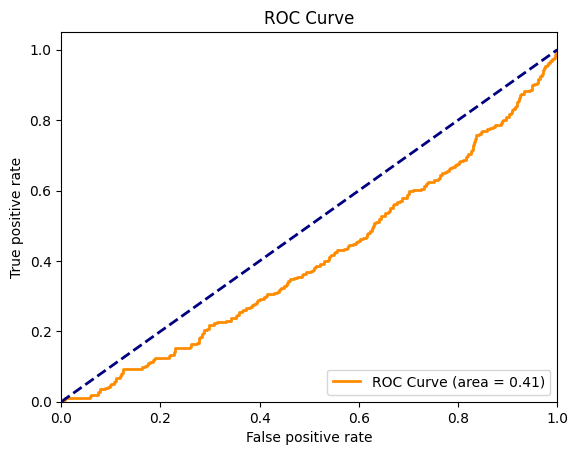

In [96]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [97]:
# create binary labels for anomalies and generate a classification report
# binary labels where 1 represents anomalies and 0 represents non-anomalies
anomaly_labels = np.where(reconstruction_errors > threshold, 1, 0)
report = classification_report(y_true, anomaly_labels)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      9744
           1       0.01      0.01      0.01       256

    accuracy                           0.93     10000
   macro avg       0.49      0.48      0.48     10000
weighted avg       0.95      0.93      0.94     10000

